In [1]:
import nltk
import numpy as np

from nltk.corpus import movie_reviews

nltk.download('movie_reviews')

NUM_SAMPLES = 1000
fileids = np.asarray(movie_reviews.fileids())

idx = np.concatenate([
    np.arange(NUM_SAMPLES // 2), 
    np.arange(len(fileids) - NUM_SAMPLES // 2, len(fileids))
])

print(fileids[idx])

['neg/cv000_29416.txt' 'neg/cv001_19502.txt' 'neg/cv002_17424.txt'
 'neg/cv003_12683.txt' 'neg/cv004_12641.txt' 'neg/cv005_29357.txt'
 'neg/cv006_17022.txt' 'neg/cv007_4992.txt' 'neg/cv008_29326.txt'
 'neg/cv009_29417.txt' 'neg/cv010_29063.txt' 'neg/cv011_13044.txt'
 'neg/cv012_29411.txt' 'neg/cv013_10494.txt' 'neg/cv014_15600.txt'
 'neg/cv015_29356.txt' 'neg/cv016_4348.txt' 'neg/cv017_23487.txt'
 'neg/cv018_21672.txt' 'neg/cv019_16117.txt' 'neg/cv020_9234.txt'
 'neg/cv021_17313.txt' 'neg/cv022_14227.txt' 'neg/cv023_13847.txt'
 'neg/cv024_7033.txt' 'neg/cv025_29825.txt' 'neg/cv026_29229.txt'
 'neg/cv027_26270.txt' 'neg/cv028_26964.txt' 'neg/cv029_19943.txt'
 'neg/cv030_22893.txt' 'neg/cv031_19540.txt' 'neg/cv032_23718.txt'
 'neg/cv033_25680.txt' 'neg/cv034_29446.txt' 'neg/cv035_3343.txt'
 'neg/cv036_18385.txt' 'neg/cv037_19798.txt' 'neg/cv038_9781.txt'
 'neg/cv039_5963.txt' 'neg/cv040_8829.txt' 'neg/cv041_22364.txt'
 'neg/cv042_11927.txt' 'neg/cv043_16808.txt' 'neg/cv044_18429.txt'
 'n

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/esten/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [2]:
from collections import Counter
from nltk.corpus import movie_reviews

reviews = []
labels = []

for fileid in fileids[idx]:
    reviews.append(movie_reviews.raw(fileid))
    labels.append(fileid.split('/')[0])
    
print(reviews[2])
print(labels[2])
print(Counter(labels))

it is movies like these that make a jaded movie viewer thankful for the invention of the timex indiglo watch . 
based on the late 1960's television show by the same name , the mod squad tells the tale of three reformed criminals under the employ of the police to go undercover . 
however , things go wrong as evidence gets stolen and they are immediately under suspicion . 
of course , the ads make it seem like so much more . 
quick cuts , cool music , claire dane's nice hair and cute outfits , car chases , stuff blowing up , and the like . 
sounds like a cool movie , does it not ? 
after the first fifteen minutes , it quickly becomes apparent that it is not . 
the mod squad is certainly a slick looking production , complete with nice hair and costumes , but that simply isn't enough . 
the film is best described as a cross between an hour-long cop show and a music video , both stretched out into the span of an hour and a half . 
and with it comes every single clich ? . 
it doesn't really 

In [4]:
import os

from openai import OpenAI

key_path = os.path.join(os.path.expanduser('~'), '.keys', 'openai')

with open(key_path, 'r') as f:
    key = f.read()
    
client = OpenAI(api_key=key)

In [5]:
from openai import OpenAI
from tqdm import tqdm



def embed(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    
    return client.embeddings.create(input = [text], model=model).data[0].embedding

embeddings = [embed(review) for review in tqdm(reviews)]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:27<00:00,  2.58it/s]


In [6]:
np.random.seed(42)

X = np.asarray(embeddings)
y = np.asarray(labels)
print(X.shape)
shuffled_idx = np.random.permutation(np.arange(len(X)))
X = X[shuffled_idx]
y = y[shuffled_idx]

train_idx = int(len(X) * 0.8)

train_X = X[:train_idx]
train_y = y[:train_idx]
test_X = X[train_idx:]
test_y = y[train_idx:]

(1000, 1536)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(train_X, train_y)

train_predictions = model.predict_proba(train_X)[:,1]
train_auc = roc_auc_score(train_y, train_predictions)
print(f'Train AUC: {train_auc:.2f}')

test_predictions = model.predict_proba(test_X)[:,1]
test_auc = roc_auc_score(test_y, test_predictions)
print(f'Test AUC: {test_auc:.2f}')

Train AUC: 0.98
Test AUC: 0.98


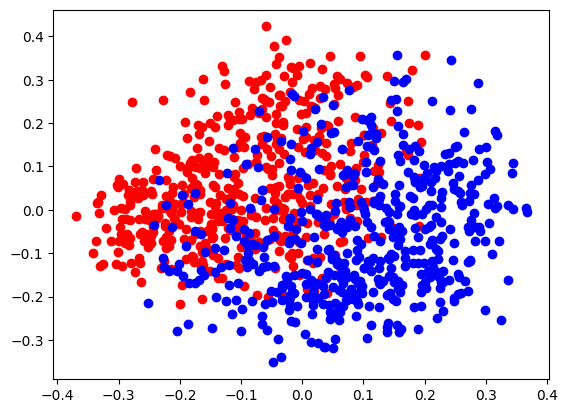

In [8]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA


pca = PCA(n_components=2)
transformed = pca.fit_transform(X)

for label, color in [('neg', 'red'), ('pos', 'blue')]:
    idx = np.where(y == label)
    plt.scatter(transformed[idx,0], transformed[idx,1], c=color)
    
plt.show()